### Validation figure [transect]
#### - This is an adaptation of Fig. 3. I am making a temperature transect north-south through the slope  with ispycnals overlaid and comparing that to WOA18 climatology. 

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.path as mpath
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cftime
import glob,os
import matplotlib.colors as col
import xarray.ufuncs as xu
import gsw

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
from glob import glob     #or else you get an error when trying to load the WOA files

##not sure why this is here
from matplotlib.cm import ScalarMappable

# set to your figure directory location:
#figdir = '/g/data/v45/akm157/figures/Antarctic_tides_fixed/temp_transect_movie/'

In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:44857' processes=7 threads=7, memory=32.00 GiB>

### LOAD MODEL DATA

### 2018 to compare with WOA18

In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '2005'
last_year = '2017'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

# set this to the rough region of interest:
lon_slice  = slice(-258, -248)
lat_slice  = slice(-67.5, -61)

In [4]:
# get temp and salt to calculate lines:
temp = cc.querying.getvar(cycle3,'temp',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly') - 273.15
temp = temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

salt = cc.querying.getvar(cycle3,'salt',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly')
salt = salt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

#### Plot map of chosen transect

In [6]:
# load a sample slice of data to plot just for testing:
#temp_slice = temp.sel(st_ocean=400,method='nearest').isel(time=0)
temp_slice = temp.sel(st_ocean=400,method='nearest').mean('time')
temp_slice = temp_slice.load()

# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

Text(0, 0.5, 'Latitude ($^\\circ$)')

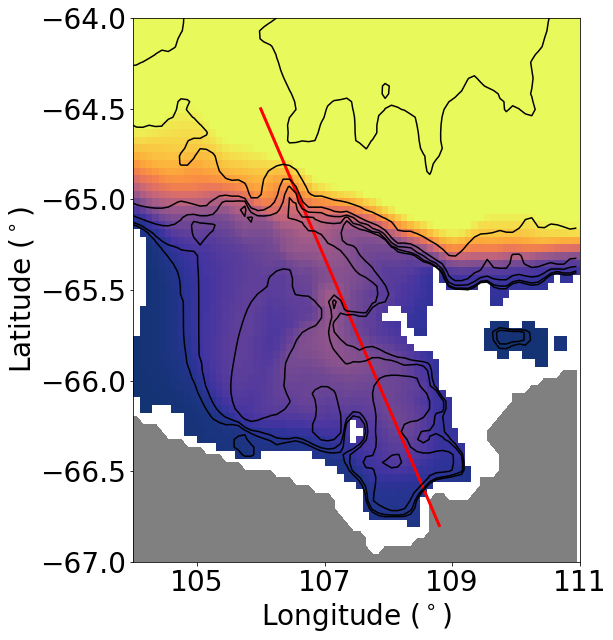

In [7]:
# define transect start and end points:
# Change these values until you get the transect you want:
lat0 = -66.8
lat1=  -64.5
lon0 = -250.2
lon1 = -253 #-254

fontsize=28

fig=plt.figure(figsize=(10,10))
ax0=plt.subplot(1,1,1)  
# plot temperature:
plt.pcolormesh(temp_slice.xt_ocean,temp_slice.yt_ocean,temp_slice, cmap=cmocean.thermal,
              vmin=-2,vmax=0)
cbar=plt.colorbar()
#plt.clim((-2.1,.8))

# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r',linewidth='3')
plt.xlim((-255, -248))
plt.ylim((-67, -64))
# plot bathymetry contours:
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[500,550,700,1000,2000,3000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.tick_params(labelsize=fontsize)

cbar.ax.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'Temperature ($^\circ$C)', fontsize = 18,labelpad=5)
# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0.set_xticklabels([-256+359,-254+359,-252+359,-250+359,-248+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)

#figdir = '/home/581/ns3783/Scripts/Figures/New_codes_CFD/Figures'
#filestr = figdir+'/Fig2_map.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [8]:
#temp

### extract nearest points along transect 

In [8]:
# Note that this cell is slow, but it will load the entire timeseries along the transect 
# (which means you could later make movies of this or look at different snapshots):
#this is wrong for salt and T because I have avg them

lons = [lon0, lon1]
lats = [lat0, lat1]

yt_ocean = temp.yt_ocean

# get latitude of points along transect:
lat_transect = yt_ocean.sel(yt_ocean = slice(lats[0],lats[1])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yt_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yt_ocean')

# Extract temp and salt along transect:
temp_transect = temp.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
salt_transect = salt.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')

# bathymetry along transect:
ht_transect = ht.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
ht_transect = ht_transect.fillna(0)

# calculate density along transect:
# arrays for gsw to use
depth_array = temp_transect*0 + temp_transect.st_ocean
lat_array = temp_transect*0 + temp_transect.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(salt_transect,pressure,lon_transect,lat_array)
sigma0 = gsw.sigma0(salt_abs,temp_transect)
# convert back to xarray for multiplying later:
sigma0 = xr.DataArray(sigma0,
                      coords = [temp_transect.time, temp_transect.st_ocean,temp_transect.yt_ocean],
                      dims = ['time','st_ocean','yt_ocean'])

In [9]:
# load data before plotting:
sigma0 = sigma0.load()
temp_transect = temp_transect.load()


In [10]:
# averaging data to get a year product
sigma0=sigma0.mean('time')
temp_transect=temp_transect.mean('time')

## WOA18
### Things of note, when comparing to the WOA13 product:
### - I believe it is not in the model grid
    ####   - 1st problem is that the lon values are different
    ####   - 2nd and worst problem is that we will have to interpolate the depth onto the model grid.
### - Objectively analyzed climatologies are the resulting mean fields for an oceanographic variable at standard depth levels for the World Ocean. So the variable we want is an.

#### checking the data for the first time, while looking into gadi README documentation and also the actual wo18 documentation

#### load wod18 salt

In [11]:
##  there are a couple of differences here. S and T are stored on different sets of files, so we have to load them seperately
path2files   = '/g/data/ik11/observations/woa18/'
FileList = glob(path2files+'woa18_A5B7_s*')
FileList.sort()

In [12]:
FileList

['/g/data/ik11/observations/woa18/woa18_A5B7_s01_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_s02_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_s03_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_s04_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_s05_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_s06_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_s07_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_s08_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_s09_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_s10_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_s11_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_s12_04.nc']

In [13]:
%%time
# set this to the rough region of interest:
lon_slice  = slice(104, 114) ## another issue is the longitude. I believe it is not in the model grid 
lat_slice  = slice(-67.5, -61)

# Define file paths
file_paths = FileList

# Load data for each file and concatenate along time dimension
ds_list = []
for file_path in file_paths:
    # Load data and select slices for GRID_X_T and GRID_Y_T dimensions
    ds = xr.open_dataset(file_path).sel(lon=lon_slice, lat=lat_slice)
    ds_list.append(ds)

# Concatenate datasets along time dimension
ds_concat1 = xr.concat(ds_list, dim="time")

CPU times: user 11.7 s, sys: 1.74 s, total: 13.5 s
Wall time: 22.5 s


In [14]:
## correct longitude
ds_concat1 = ds_concat1.assign_coords(lon=(ds_concat1['lon'] - 360))

In [15]:
## calculate annual average and create two independent variables 
sal_woa18 = ds_concat1['s_an'].groupby('time.year').mean(dim='time')

#### load woa18 temp

In [16]:
##  there are a couple of differences here. S and T are stored on different sets of files, so we have to load them seperately
path2files   = '/g/data/ik11/observations/woa18/'
FileList = glob(path2files+'woa18_A5B7_t*')
FileList.sort()

In [17]:
FileList

['/g/data/ik11/observations/woa18/woa18_A5B7_t01_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_t02_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_t03_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_t04_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_t05_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_t06_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_t07_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_t08_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_t09_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_t10_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_t11_04.nc',
 '/g/data/ik11/observations/woa18/woa18_A5B7_t12_04.nc']

In [18]:
 ds = xr.open_dataset('/g/data/ik11/observations/woa18/woa18_A5B7_t01_04.nc')

In [19]:
ds

<xarray.Dataset>
Dimensions:             (lat: 720, nbounds: 2, lon: 1440, depth: 57, time: 1,
                         climatology_bounds: 2)
Coordinates:
  * lat                 (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) datetime64[ns] 2011-01-01T17:59:59.500000
  * climatology_bounds  (climatology_bounds) datetime64[ns] 2005-01-01 2017-1...
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    t_an                (time, depth, lat, lon) float32 ...
    t_mn                (time, depth, lat, lon) float32 ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
    t_oa                (time, depth, lat, lon) float32 ...
    t_ma                (time, depth, lat, lon) float32 ...
    t_gp                (time, depth, lat, lon) float64 ...
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-28 
    date_modified:                   2019-07-28

In [20]:
%%time
# set this to the rough region of interest:
lon_slice  = slice(104, 114) ## another issue is the longitude. I believe it is not in the model grid 
lat_slice  = slice(-67.5, -61)

# Define file paths
file_paths = FileList

# Load data for each file and concatenate along time dimension
ds_list = []
for file_path in file_paths:
    # Load data and select slices for GRID_X_T and GRID_Y_T dimensions
    ds = xr.open_dataset(file_path).sel(lon=lon_slice, lat=lat_slice)
    ds_list.append(ds)

# Concatenate datasets along time dimension
ds_concat2 = xr.concat(ds_list, dim="time")

CPU times: user 11.8 s, sys: 1.25 s, total: 13.1 s
Wall time: 22 s


In [21]:
ds_concat2

<xarray.Dataset>
Dimensions:             (time: 12, lat: 26, nbounds: 2, lon: 40, depth: 57,
                         climatology_bounds: 2)
Coordinates:
  * lat                 (lat) float32 -67.38 -67.12 -66.88 ... -61.38 -61.12
  * lon                 (lon) float32 104.1 104.4 104.6 ... 113.4 113.6 113.9
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) datetime64[ns] 2011-01-01T17:59:59.500000 ... ...
  * climatology_bounds  (climatology_bounds) datetime64[ns] 2005-01-01 2017-1...
Dimensions without coordinates: nbounds
Data variables:
    crs                 (time) int32 -2147483647 -2147483647 ... -2147483647
    lat_bnds            (time, lat, nbounds) float32 -67.5 -67.25 ... -61.0
    lon_bnds            (time, lon, nbounds) float32 104.0 104.2 ... 113.8 114.0
    depth_bnds          (time, depth, nbounds) float32 0.0 2.5 ... 1.5e+03
    t_an                (time, depth, lat, lon) float32 nan nan ... 1.213 1.227
    t_mn                (time, depth, lat, lon) float32 nan nan nan ... nan nan
    t_dd                (time, depth, lat, lon) float64 nan nan nan ... 0.0 0.0
    t_sd                (time, depth, lat, lon) float32 nan nan nan ... nan nan
    t_se                (time, depth, lat, lon) float32 nan nan nan ... nan nan
    t_oa                (time, depth, lat, lon) float32 nan nan nan ... nan nan
    t_ma                (time, depth, lat, lon) float32 nan nan ... -0.0168
    t_gp                (time, depth, lat, lon) float64 nan nan ... 43.0 40.0
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-28 
    date_modified:                   2019-07-28

In [22]:
## correct longitude
ds_concat2 = ds_concat2.assign_coords(lon=(ds_concat2['lon'] - 360))

In [23]:
# Convert potential temperature to conservative temperature
ds_concat1 = ds_concat1.load()
ds_concat2 = ds_concat2.load()

# define the conversion function
def convert_temp(temp, salt, depth):
    # create a boolean mask for NaN values
    mask = np.isnan(temp) | np.isnan(salt) | np.isnan(depth)
    # calculate potential temperature for non-NaN values
    pt = np.where(mask, np.nan, gsw.conversions.pt_from_CT(salt, temp))
    # calculate conservative temperature for non-NaN values
    ct = np.where(mask, np.nan, gsw.conversions.CT_from_pt(salt, pt))
    return ct

# apply the function to the temp variable in ds_concat
ds_concat2['temp_conserv'] = xr.apply_ufunc(convert_temp, ds_concat2.t_an, ds_concat1.s_an,ds_concat1.depth)

In [24]:
## looks like the function works now that I am not selecting nans. 
## But I am checking with this line. If it returns true, then they are different. 
print((ds_concat2.t_an != ds_concat2.temp_conserv).any())

<xarray.DataArray ()>
array(True)


In [25]:
## calculate annual average and create two independent variables 
sal_woa18 = ds_concat1['s_an'].groupby('time.year').mean(dim='time')
temp_woa18 = ds_concat2['temp_conserv'].groupby('time.year').mean(dim='time')

In [26]:
## rename the dimensions to the same name as the model dimensions so I don't have to alter the code too much when plotting. 
temp_woa18 = temp_woa18.rename({'year': 'time', 'lat': 'yt_ocean', 'depth': 'st_ocean', 'lon': 'xt_ocean'})
sal_woa18 = sal_woa18.rename({'year': 'time', 'lat': 'yt_ocean', 'depth': 'st_ocean', 'lon': 'xt_ocean'})

In [27]:
## dropping the time dimension, as it is equal to 1 after averaging:
temp_woa18 = temp_woa18.squeeze(dim='time')
sal_woa18 = sal_woa18.squeeze(dim='time')

In [28]:
## load variables
temp_woa18 = temp_woa18.load()
sal_woa18 = sal_woa18.load()

In [29]:
temp

<xarray.DataArray 'temp' (time: 159, st_ocean: 75, yt_ocean: 147, xt_ocean: 100)>
dask.array<getitem, shape=(159, 75, 147, 100), dtype=float32, chunksize=(1, 19, 82, 100), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -257.9 -257.8 -257.7 ... -248.2 -248.1 -248.0
  * yt_ocean  (yt_ocean) float64 -67.47 -67.42 -67.38 ... -61.13 -61.08 -61.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 2004-10-16T12:00:00 ... 2017-12-16T12:00:00

### Interp woa18 data to model z grid

#### - it seems I have loaded the variables, but I think I have to interpolate them to the model z grid
#### - I am going to try to do that with xrray

In [30]:
sal_woa18 = sal_woa18.interp(st_ocean=temp.st_ocean, method='linear')
temp_woa18 = temp_woa18.interp(st_ocean=temp.st_ocean, method='linear')

### Interp woa18 data to model x and y grid

#### - it seems I have loaded the variables, but I think I have to interpolate them to the model x&y grid
#### - I am going to try to do that with xrray

In [31]:
sal_woa18 = sal_woa18.interp(yt_ocean=temp.yt_ocean, method='linear')
temp_woa18 = temp_woa18.interp(yt_ocean=temp.yt_ocean, method='linear')

sal_woa18 = sal_woa18.interp(xt_ocean=temp.xt_ocean, method='linear')
temp_woa18 = temp_woa18.interp(xt_ocean=temp.xt_ocean, method='linear')

#### Plot map of chosen transect

In [32]:
# have to recall this for loading bathymetry data
lon_slice  = slice(-258, -248)
lat_slice  = slice(-67.5, -61)


# load a sample slice of data to plot just for testing:
#temp_slice = temp.sel(st_ocean=400,method='nearest').isel(time=0)
temp_slice2 = temp_woa18.sel(st_ocean=400,method='nearest')
temp_slice2 = temp_slice2.load()

# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

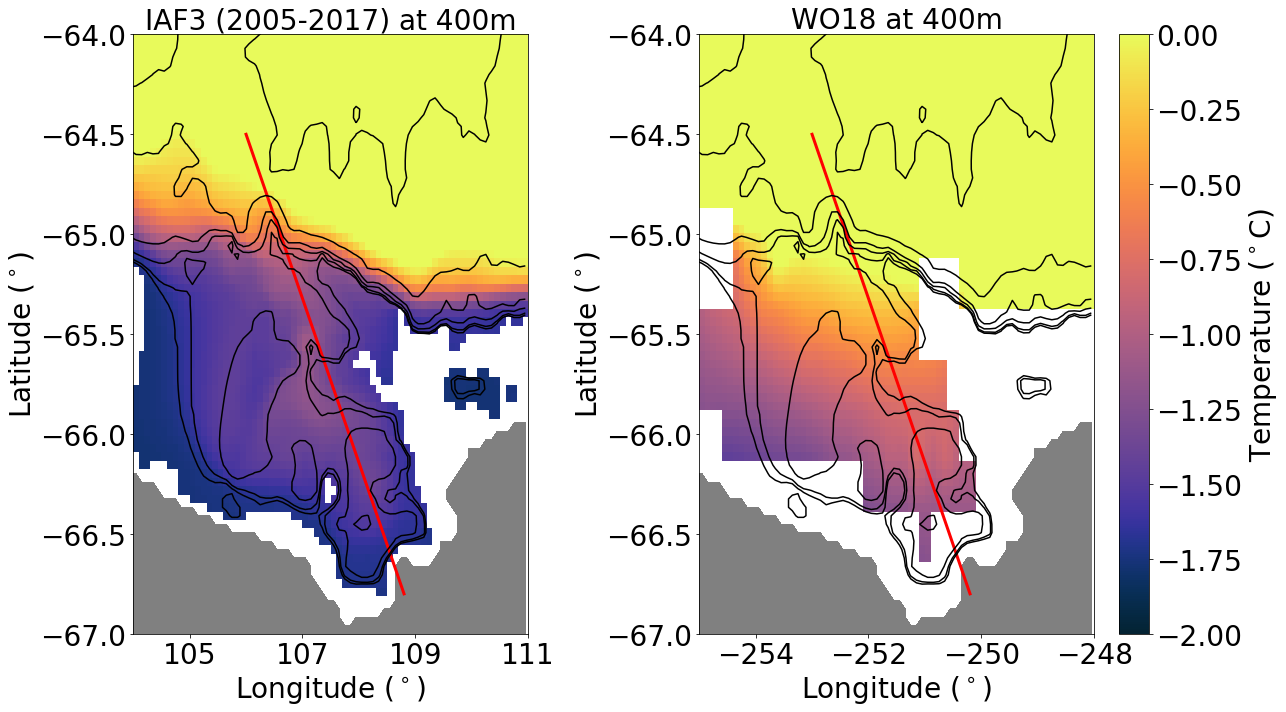

In [33]:
# define transect start and end points:
# Change these values until you get the transect you want:
lat0 = -66.8
lat1=  -64.5
lon0 = -250.2
lon1 = -253 #-254

fontsize=28

fig = plt.figure(1,figsize=(18,10))
fig.subplots_adjust(top=0.88)

ax0=plt.subplot(1,2,1)
# plot temperature:
plt.pcolormesh(temp_slice.xt_ocean,temp_slice.yt_ocean,temp_slice, cmap=cmocean.thermal,
              vmin=-2,vmax=0)
cbar=plt.colorbar()
#plt.clim((-2.1,.8))

# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r',linewidth='3')
plt.xlim((-255, -248))
plt.ylim((-67, -64))
# plot bathymetry contours:
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[500,550,700,1000,2000,3000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.tick_params(labelsize=fontsize)

cbar.ax.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'Temperature ($^\circ$C)', fontsize = 18,labelpad=5)
# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0.set_xticklabels([-256+359,-254+359,-252+359,-250+359,-248+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('IAF3 (2005-2017) at 400m',fontsize=fontsize)


ax1=plt.subplot(1,2,2)
# plot temperature:
plt.pcolormesh(temp_slice2.xt_ocean,temp_slice2.yt_ocean,temp_slice2, cmap=cmocean.thermal,
              vmin=-2,vmax=0)
cbar=plt.colorbar()
#plt.clim((-2.1,.8))

# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r',linewidth='3')
plt.xlim((-255, -248))
plt.ylim((-67, -64))
# plot bathymetry contours:
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[500,550,700,1000,2000,3000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.tick_params(labelsize=fontsize)

cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Temperature ($^\circ$C)', fontsize = fontsize,labelpad=5)
# this removes colorbar whilst maintaing figure size
#fig.delaxes(fig.axes[1])

ax0.set_xticklabels([-256+359,-254+359,-252+359,-250+359,-248+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('WO18 at 400m',fontsize=fontsize)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir+'/Fig_IAF3vsWO18_400m.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

### extract nearest points along transect 

In [35]:
# Note that this cell is slow, but it will load the entire timeseries along the transect 
# (which means you could later make movies of this or look at different snapshots):
#this is wrong for salt and T because I have avg them

lons = [lon0, lon1]
lats = [lat0, lat1]

yt_ocean = temp.yt_ocean

# get latitude of points along transect:
lat_transect = yt_ocean.sel(yt_ocean = slice(lats[0],lats[1])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yt_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yt_ocean')

# Extract temp and salt along transect:
temp_transect_woa18 = temp_woa18.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
salt_transect_woa18 = sal_woa18.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')

# bathymetry along transect:
ht_transect = ht.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
ht_transect = ht_transect.fillna(0)

# calculate density along transect:
# arrays for gsw to use
depth_array = temp_transect_woa18*0 + temp_transect_woa18.st_ocean
lat_array = temp_transect_woa18*0 + temp_transect_woa18.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(salt_transect_woa18,pressure,lon_transect,lat_array)

sigma0_woa18 = gsw.sigma0(salt_abs,temp_transect_woa18)
# convert back to xarray for multiplying later:
sigma0_woa18 = xr.DataArray(sigma0_woa18,
                      coords = [temp_transect.st_ocean,temp_transect.yt_ocean],
                      dims = ['st_ocean','yt_ocean'])

In [36]:
sigma0_woa18

<xarray.DataArray 's_an' (st_ocean: 75, yt_ocean: 55)>
array([[        nan,         nan,         nan, ..., 27.41368305,
        27.40998343, 27.40671021],
       [        nan,         nan,         nan, ..., 27.41399675,
        27.41029379, 27.40701371],
       [        nan,         nan,         nan, ..., 27.41434343,
        27.41063677, 27.40734912],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yt_ocean  (yt_ocean) float64 -66.79 -66.75 -66.71 ... -64.59 -64.55 -64.5

In [37]:
# load data before plotting:
sigma0_woa18 = sigma0_woa18.load()
temp_transect_woa18 = temp_transect_woa18.load()


### plot comparison temp transects with isopycnal overlaid for IAF3 (avg 2005 to 2017) and WOA18 climatology

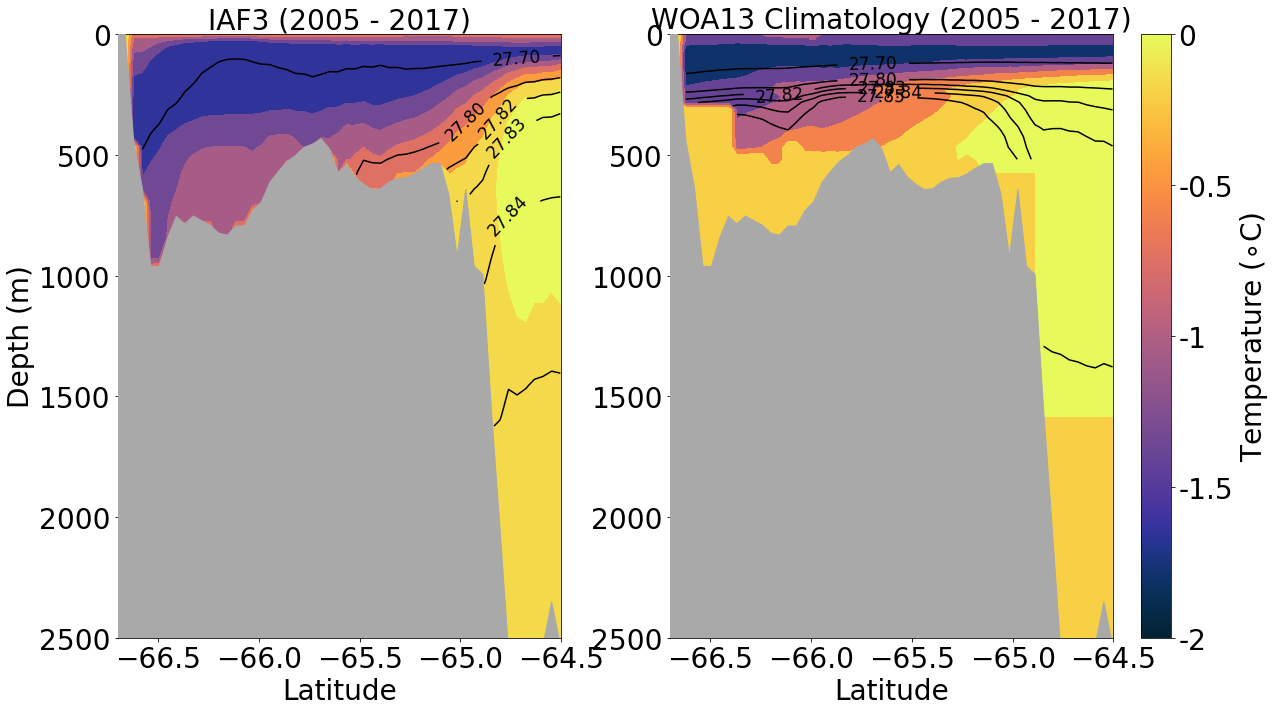

In [38]:
fontsize2 = 28
# choose density contours that work for your transect:
#density_contours = [27.7,27.8,27.83,27.84,27.85,27.9,28]
density_contours = [27.7,27.8,27.82,27.83,27.84,27.85,27.9,28]

# set up figure and projection:
fig = plt.figure(1,figsize=(18,10))
fig.subplots_adjust(top=0.88)

ax0 = plt.subplot(1, 2, 1) 
# plot temperature:
pcm = plt.contourf(temp_transect.yt_ocean, temp_transect.st_ocean, temp_transect.fillna(0),
           cmap = cmocean.thermal, vmin=-2, vmax=0)
pcm.set_clim(-2, 0)

plt.tick_params(labelsize=fontsize2)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:ww
plt.ylim((2500,0))
plt.xlim((-66.7,-64.5))
plt.ylabel('Depth (m)',fontsize=fontsize2)
plt.xlabel('Latitude',fontsize=fontsize2)
plt.title('IAF3 (2005 - 2017)',fontsize=fontsize2)

#cbar=plt.colorbar()
cbar = fig.colorbar(
   ScalarMappable(norm=pcm.norm, cmap=pcm.cmap),
   ticks=range(-2,0)
)
cbar.ax.tick_params(labelsize=fontsize2)
cbar.set_label(r'Temperature ($\circ$C)', fontsize = fontsize2,labelpad=5)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

# plot density contours:
cont = plt.contour(sigma0.yt_ocean,sigma0.st_ocean,sigma0,density_contours,
           colors='k',zorder=2 ,fontsize=17)
plt.clabel(cont, inline=1, fontsize=17,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')


ax1 = plt.subplot(1, 2, 2)   
# plot temperature:
pcm = plt.contourf(temp_transect_woa18.yt_ocean,temp_transect_woa18.st_ocean,temp_transect_woa18.fillna(0),
           cmap = cmocean.thermal,vmin=-2,vmax=0)

plt.tick_params(labelsize=fontsize2)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((2500,0))
plt.xlim((-66.7,-64.5))
#plt.ylabel('Depth (m)',fontsize=fontsize2)
plt.xlabel('Latitude',fontsize=fontsize2)
plt.title('WOA13 Climatology (2005 - 2017)',fontsize=fontsize2)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar = fig.colorbar(
   ScalarMappable(norm=pcm.norm, cmap=pcm.cmap),
   ticks=range(-2,0)
)
cbar.ax.tick_params(labelsize=fontsize2)
cbar.set_label(r'Temperature ($\circ$C)', fontsize = fontsize2,labelpad=5)
# set the tick positions and labels for the second colorbar
ticks = [-2, -1.5, -1, -0.5, 0]
ticklabels = ['-2', '-1.5', '-1', '-0.5' ,'0']
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)

# plot density contours:
cont = plt.contour(sigma0_woa18.yt_ocean,sigma0_woa18.st_ocean,sigma0_woa18,density_contours,
           colors='k',zorder=2 ,fontsize=17)
plt.clabel(cont, inline=2, fontsize=17,fmt='%1.2f')


# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/transect_IAF3vsWOA18.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')